## Pytorch - ONNX/ONNX GPU - Tensorflow

### Preprocessing

In [ ]:
# Installing necessary library
!pip install tensorboard
!pip install onnx
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
# Import necessary library
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tensorflow.python.client import device_lib
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# For reproducibility of NumPy, and Tensorflow random operations
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load the TensorBoard extension for visualization
%load_ext tensorboard

In [ ]:
# Print Python and TensorFlow versions
print("Python Version:", sys.version_info)
print("TensorFlow Version:", tf.__version__)

# List available physical devices
print("\nAvailable Physical Devices:")
for device in tf.config.list_physical_devices():
    print(device)

# List local devices (with more detailed info like device name/type)
print("\nLocal Devices Info:")
devices = device_lib.list_local_devices()
for device in devices:
    print(f"{device.device_type}: {device.name} - {device.physical_device_desc}")

Python Version: sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
TensorFlow Version: 2.18.0

Available Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Local Devices Info:
CPU: /device:CPU:0 - 
GPU: /device:GPU:0 - device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


In [ ]:
# Import necessary library
import shutil
import os

# Copy file using Shutil
def safe_copy_file(src_path, dst_dir):
    """
    Copy a file safely using shutil.
    If the destination directory doesn't exist, it will be created.
    The file will be copied with its original name.
    """
    if not os.path.exists(src_path):
        print(f"Source file does not exist: {src_path}")
        return

    os.makedirs(dst_dir, exist_ok=True)

    # Keep original file name
    filename = os.path.basename(src_path)
    dst_path = os.path.join(dst_dir, filename)

    try:
        shutil.copy(src_path, dst_path)
        print(f"File copied successfully: {dst_path}")
    except Exception as e:
        print(f"Error copying file: {e}")

# Copy folder using copytree
def safe_copy_folder(src_folder, dst_folder, dirs_exist=False):
    if not os.path.exists(src_folder):
        print(f"Source folder does not exist: {src_folder}")
        return

    try:
        shutil.copytree(src_folder, dst_folder, dirs_exist_ok=dirs_exist)
        print(f"Folder copied successfully: {dst_folder}")
    except FileExistsError:
        print(f"Destination folder already exists: {dst_folder}")
    except Exception as e:
        print(f"Error copying folder: {e}")

In [ ]:
# Import necessary library
from google.colab import drive
import zipfile

# Mount drive
drive.mount('/content/drive')

# Directory of source and destination
src = '/content/drive/MyDrive/eye_diseases_classification.zip'
dst = '/content'

safe_copy_file(src, dst)

# Unzip file
with zipfile.ZipFile("/content/eye_diseases_classification.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/eye_diseases_classification")

Mounted at /content/drive
File copied successfully: /content/eye_diseases_classification.zip


### Export from Pytorch to ONNX

In [ ]:
import torch
import torchvision.models as models

# Example: Use squeezenet1.1
model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.DEFAULT)
model.eval()

# Remove classifier (keep only feature extractor)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # removes classifier

# Dummy input (size must match expected model input)
dummy_input = torch.randn(1, 3, 224, 224)

# Export the model
torch.onnx.export(
    feature_extractor,
    dummy_input,
    "squeezenet1_1.onnx",
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=11
)

### ONNX GPU

In [ ]:
import onnxruntime as ort
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
ONNX_MODEL_PATH = "/content/squeezenet1_1.onnx"  # ONNX model
dataset_path = '/content/eye_diseases_classification/dataset'

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Store class names before prefetching
class_names = dataset.class_names  # Capture class names here
num_classes = len(dataset.class_names)

# Optimize with prefetching
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.unbatch().shuffle(5000, seed=SEED).batch(BATCH_SIZE)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 4217 files belonging to 4 classes.


### Dataset Info

In [ ]:
for images, labels in dataset.take(1):
    print([np.argmax(label.numpy()) for label in labels])

[np.int64(1), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(3), np.int64(1), np.int64(3), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(2), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(2), np.int64(0)]


In [ ]:
for images, labels in dataset.take(1):
    print("Labels shape:", labels.shape)
    print("Labels example:", labels[0].numpy())

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {class_names}\n")

print(f"information of dataset:\n{dataset.element_spec}")

Labels shape: (32, 4)
Labels example: [1. 0. 0. 0.]

Number of classes: 4
Class names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

information of dataset:
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))


Image shape: (224, 224, 3)
Label shape: (4,)
Image data type: <dtype: 'float32'>


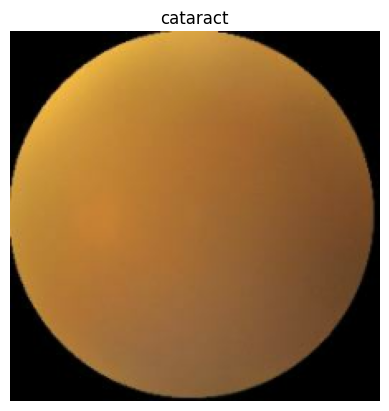

In [ ]:
# Get an image and its label from the dataset
image_batch, label_batch = next(iter(dataset))  # gets a batch
image = image_batch[0]
label = label_batch[0]

print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")
print(f"Image data type: {image.dtype}")

# Plot
plt.imshow(image.numpy().astype("uint8"))
# Convert label to a single index before using it to access class_names
predicted_class_index = np.argmax(label.numpy()) # get the index of the predicted class
plt.title(class_names[predicted_class_index]) # use the index to access class_names
plt.axis('off')
plt.show()

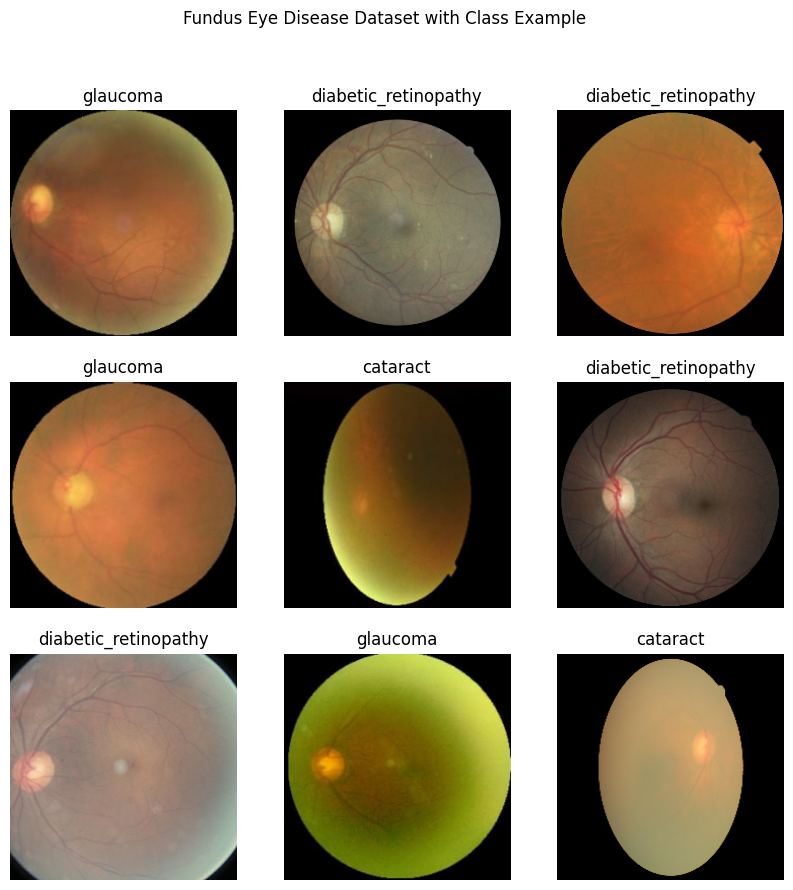

In [ ]:
# Visualize several data from dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.suptitle('Fundus Eye Disease Dataset with Class Example')
        plt.imshow(images[i].numpy().astype("uint8"))
        # Get the index of the true class from the one-hot encoded label
        label_index = np.argmax(labels[i].numpy())
        plt.title(class_names[label_index])  # Use label_index to access class_names
        # plt.title(class_names[labels[i]])
        plt.axis("off")

### Main

In [ ]:
def preprocess_batch(images, labels):
    images = tf.cast(images, tf.float32) / 255.0

    # Normalize with ImageNet mean and std
    mean = tf.constant([0.485, 0.456, 0.406], shape=(1, 1, 1, 3))
    std = tf.constant([0.229, 0.224, 0.225], shape=(1, 1, 1, 3))
    images = (images - mean) / std

    # Convert NHWC → NCHW
    images = tf.transpose(images, [0, 3, 1, 2])
    return images, labels

dataset_nchw = dataset.map(preprocess_batch)

In [ ]:
# Initialize ONNX Runtime session with GPU
session = ort.InferenceSession(ONNX_MODEL_PATH, providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

features_list = []
labels_list = []

for images, labels in dataset_nchw:
    img_np = images.numpy()
    output = session.run([output_name], {input_name: img_np})[0]  # [B, 512, 13, 13]
    output = output.mean(axis=(2, 3))  # Global average pooling → [B, 512]
    features_list.append(output)
    labels_list.append(labels.numpy())

features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (4217, 512)
Labels shape: (4217, 4)


In [ ]:
print("ONNX model output shape:", output.shape)

ONNX model output shape: (25, 512)


In [ ]:
folder_name = "/content/temporary_dataset"

# Create the folder
os.makedirs(folder_name, exist_ok=True)

print(f"Folder '{folder_name}' created successfully (or already exists).")

Folder '/content/temporary_dataset' created successfully (or already exists).


In [ ]:
np.save("/content/temporary_dataset/features.npy", features)
np.save("/content/temporary_dataset/labels.npy", labels)

In [ ]:
labels = np.argmax(labels, axis=1)  # shape becomes (4217,)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (4217, 512)
Labels shape: (4217,)


In [ ]:
np.save("/content/temporary_dataset/encoded_labels.npy", labels)

In [ ]:
src_path = '/content/temporary_dataset'
dst_path = '/content/drive/MyDrive/Testing_Pytorch_to_Tensorflow_new'

safe_copy_folder(src_path, dst_path, dirs_exist=True)

Folder copied successfully: /content/drive/MyDrive/Testing_Pytorch_to_Tensorflow_new


In [ ]:
# Load extracted features
# features = np.load("/content/temporary_dataset/features.npy")
# labels = np.load("/contenttemporary_dataset/labels.npy")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split dataset after future extraction
X_train, X_val, y_train, y_val = train_test_split(
    features,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


Dataset Distribution:
Total Training samples: 3373
Total Validation samples: 844


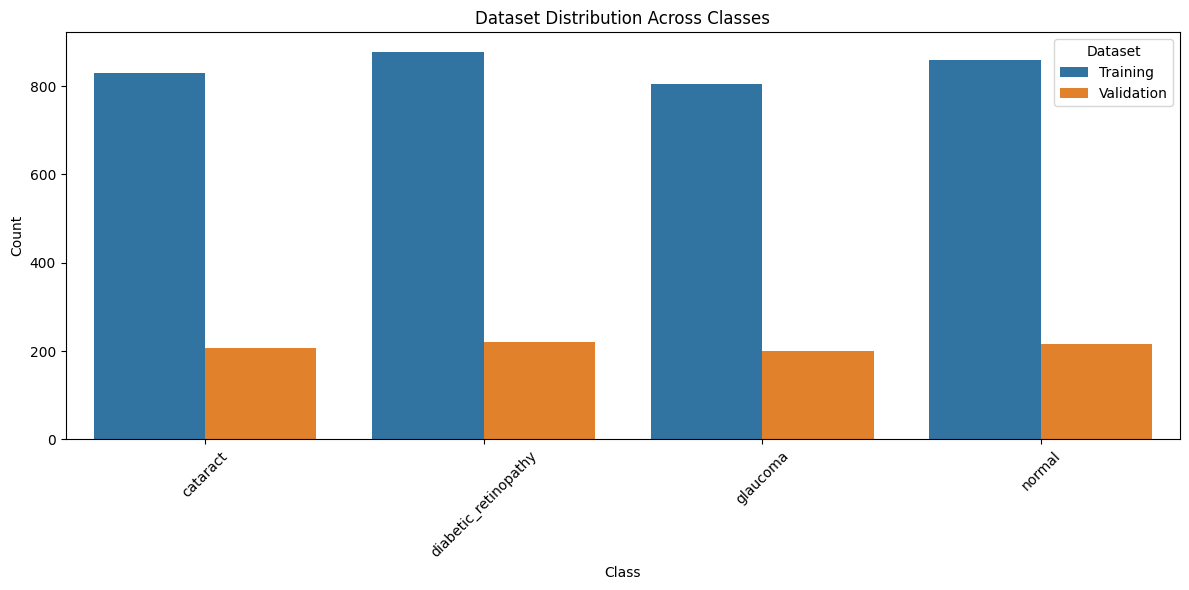


Class-wise Distribution:
               Class  Training  Validation
            cataract       830         208
diabetic_retinopathy       878         220
            glaucoma       806         201
              normal       859         215


In [ ]:
# Count samples per class using NumPy arrays (compatible with train_test_split)
def count_samples_numpy(y_data):
    return np.bincount(y_data, minlength=len(class_names))

# Count for training and validation sets
train_counts = count_samples_numpy(y_train)
valid_counts = count_samples_numpy(y_val)

# Create DataFrame for visualization
df = pd.DataFrame({
    'Class': class_names,
    'Training': train_counts,
    'Validation': valid_counts
})

# Print total counts
print("\nDataset Distribution:")
print(f"Total Training samples: {sum(train_counts)}")
print(f"Total Validation samples: {sum(valid_counts)}")

# Create visualization
plt.figure(figsize=(12, 6))
df_melted = df.melt(id_vars=['Class'], var_name='Dataset', value_name='Count')
sns.barplot(data=df_melted, x='Class', y='Count', hue='Dataset')
plt.title('Dataset Distribution Across Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display class-wise distribution
print("\nClass-wise Distribution:")
print(df.to_string(index=False))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define classifiers
models = {
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    print(f"=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred))
    print()

=== kNN ===
Accuracy: 0.8306
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       208
           1       0.95      0.86      0.91       220
           2       0.89      0.65      0.75       201
           3       0.74      0.85      0.79       215

    accuracy                           0.83       844
   macro avg       0.84      0.83      0.83       844
weighted avg       0.84      0.83      0.83       844


=== Decision Tree ===
Accuracy: 0.7690
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       208
           1       0.85      0.90      0.87       220
           2       0.68      0.64      0.66       201
           3       0.70      0.71      0.70       215

    accuracy                           0.77       844
   macro avg       0.77      0.77      0.77       844
weighted avg       0.77      0.77      0.77       844


=== Random Forest ===
Accuracy: 0.8756
              precisi